# Quant Researcher Internship - Test Assignment - Oscar Cray
## 1. Entity Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

#make plots look nice
import scienceplots
plt.style.use("science")
plt.style.use("seaborn-v0_8-dark-palette")
plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fontT = 16
font = 14

WM_dat = pd.read_csv("/home/oscar239146/Work/Syntagma/wintermute_transfers_search_default_2025-04-08.csv", header = 0) #read data into pd DF


In [2]:
WM_dat.info(), WM_dat.describe() #load basic df info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437000 entries, 0 to 436999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     437000 non-null  object 
 1   from_address  436982 non-null  object 
 2   from_entity   403700 non-null  object 
 3   to_address    436974 non-null  object 
 4   to_entity     407141 non-null  object 
 5   token         436955 non-null  object 
 6   value         437000 non-null  float64
 7   usd           437000 non-null  float64
 8   tx_hash       436956 non-null  object 
 9   chain         437000 non-null  object 
 10  block_number  436956 non-null  float64
dtypes: float64(3), object(8)
memory usage: 36.7+ MB


(None,
               value           usd  block_number
 count  4.370000e+05  4.370000e+05  4.369560e+05
 mean   1.968029e+08  4.529982e+03  2.912209e+08
 std    1.600531e+10  1.047393e+05  1.007091e+08
 min    0.000000e+00  0.000000e+00  2.222090e+07
 25%    2.788714e-01  5.000150e+01  3.241597e+08
 50%    5.953352e+00  2.332162e+02  3.320278e+08
 75%    3.159202e+02  1.172169e+03  3.320692e+08
 max    2.317466e+12  1.910000e+07  3.321093e+08)

In [3]:
#use pandas to load only entity names != Wintermute, neglect absent names
to_df_named = WM_dat[
    (WM_dat["to_entity"] != "Wintermute") & (~pd.isna(WM_dat["to_entity"]))
][["to_address", "to_entity", "chain"]].drop_duplicates().rename(columns={"to_address": "address", "to_entity": "entity"})

from_df_named = WM_dat[
    (WM_dat["from_entity"] != "Wintermute") & (~pd.isna(WM_dat["from_entity"]))
][["from_address", "from_entity", "chain"]].drop_duplicates().rename(columns={"from_address": "address", "from_entity": "entity"})

named_df = pd.concat([to_df_named, from_df_named]).drop_duplicates().reset_index(drop=True)

#Do same but for anonymous entities
to_df_anon = WM_dat[
    pd.isna(WM_dat["to_entity"]) & ~pd.isna(WM_dat["to_address"])
][["to_address", "chain"]].drop_duplicates().rename(columns={"to_address": "address"})
from_df_anon = WM_dat[
    pd.isna(WM_dat["from_entity"]) & ~pd.isna(WM_dat["from_address"])
][["from_address", "chain"]].drop_duplicates().rename(columns={"from_address": "address"})

anon_df = pd.concat([to_df_anon, from_df_anon]).drop_duplicates().reset_index(drop=True)
anon_df["entity"] = None 

#Concatenate anonymous and named info
all_CPs = pd.concat([named_df, anon_df]).drop_duplicates().reset_index(drop=True)
all_CPs["address"] = all_CPs["address"][all_CPs["address"]!=None].str.lower()
all_CPs["entity"] = all_CPs["entity"][all_CPs["entity"]!=None].str.lower()


#store all entities with different names and addresses, no duplicate addresses
CP_list = []
for i in range(len(all_CPs)):
    if all_CPs["entity"][i] != None:
        CP_list.append(all_CPs["entity"][i])
    else:
        CP_list.append(all_CPs["address"][i])
CP_list = np.unique(np.array(CP_list))  
print("All Counterparties (wallet address or name):", CP_list)

All Counterparties (wallet address or name): ['0x' '0x0000000000000000000000000000000000000000'
 '0x0000000000000000000000000000000000000008' ...
 'zvjrfrumqmppjkwncanguswlgb2jt1k6fggwwc5pspq'
 'zyftg8yhdwgtvi77ayanryvusbwfnkbfbp97sw2dxue'
 'zytc2lnknhce1i1gfxhemvanhxgqjxeu5y8yyjfjvzx']


In [4]:
import requests

#load up json of DefiLlama api protocols and store as df
response = requests.get("https://api.llama.fi/protocols")
protocols = response.json()
prot_df = pd.DataFrame(protocols)

prot_df["address"] = prot_df["address"][prot_df["address"]!=None].str.lower()
prot_df["name"] = prot_df["name"][prot_df["name"]!=None].str.lower()
prot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5988 entries, 0 to 5987
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        5988 non-null   object 
 1   name                      5988 non-null   object 
 2   address                   3265 non-null   object 
 3   symbol                    5988 non-null   object 
 4   url                       5988 non-null   object 
 5   description               5987 non-null   object 
 6   chain                     5580 non-null   object 
 7   logo                      5988 non-null   object 
 8   audits                    5976 non-null   object 
 9   audit_note                6 non-null      object 
 10  gecko_id                  1987 non-null   object 
 11  cmcId                     1550 non-null   object 
 12  category                  5988 non-null   object 
 13  chains                    5988 non-null   object 
 14  module  

In [5]:
import re

#Use re to create function to remove brackets and their info from a string
def remove_brackets(text):
    return re.sub(r"\([^)]*\)", "", text)

In [6]:
from thefuzz import fuzz

defi_ents = []
defi_adds = []
results = []

#loop over all counterparty info
for i in range(len(all_CPs)):
    done = False
    no_name = False
    if all_CPs["address"][i] != None:
        add = all_CPs["address"][i].lower() #make addresses lower case to avoid false mismatches
        for prot in prot_df["address"]: #loop over protocol addresses
            if prot != None:
                if add in prot.lower(): #check for entity address within protocol address strings
                    defi_adds.append(all_CPs["address"][i])
                    done = True
                    no_name = True
                    break
    if not done: #check CP name instead if no address match
        if all_CPs["entity"][i] != None:
            name = remove_brackets(all_CPs["entity"][i].lower()).strip()
            for prot in prot_df["name"]:
                if prot != None:
                    if name[0] == "@": #@ accounts are personal and not DeFi
                        break
                    #elif fuzz.partial_ratio(name, prot.lower()) > 90:
                    elif fuzz.ratio(name, prot.lower()) > 70:#use fuzzy match to match names
                        defi_ents.append(name)
                        done = True
                        break
    if no_name: #store protocol name if address matched
        results.append({
                "address": all_CPs["address"][i],
                "entity": prot_df.loc[prot_df["address"] == prot, "name"].values[0],
                "is_defi": done
        })
    else:
        results.append({
                "address": all_CPs["address"][i],
                "entity": all_CPs["entity"][i],
                "is_defi": done
        })

# Convert to DataFrame
defi_df = pd.DataFrame(results)


In [7]:
defi_list = defi_df["entity"][defi_df["is_defi"] == True].unique() #all DeFi addresses now named
defi_address = defi_df["address"][defi_df["is_defi"] == True].unique()[-1] # only thorchain dex is unique
print("DeFi Entities:", defi_list)

non_defi = defi_df[defi_df["is_defi"] == False]
non_defi_list = non_defi.apply(
    lambda row: row["entity"] if pd.notna(row["entity"]) and row["entity"] != "" else row["address"],
    axis=1).unique()
print("Non-DeFi Entities:", non_defi_list)


DeFi Entities: ['pancakeswap' 'uniswap' 'cow protocol' 'fluid (instadapp)' 'orca'
 'aerodrome finance' 'raydium' 'jito' 'meteora (prev. mercurial)'
 'camelot' 'phoenix' 'metamask' 'binance' 'paraswap' 'bebop' 'curve.fi'
 'bitstamp' '0x' 'crypto.com' 'lifi' 'sushiswap' 'rizzolver (wintermute)'
 'kraken' 'lifinity' 'bybit' 'zerion' 'gate.io' 'bitfinex' 'kucoin' 'okx'
 'unizen' 'shibaswap' 'rainbow.me' 'coinbase' 'velodrome finance' 'odos'
 'kyber network' 'backpack exchange' 'ethena' 'bitmart' 'circle'
 'thorchain dex']
Non-DeFi Entities: ['rsync-builder' '@yiiii420' '1inch' ...
 '3hvjmvfrftufw5wmsoa1sweggqmdf6t3wozannym5hh6'
 'hzwkmtkew9ozxzgjd7n6fygx2m9axihyugdfgkurwpis'
 '8uwgyinsysbyxvqaw2bvxccxfyhzdw6rtfqc4x6vimpv']


## 2. DeFi-Only Analysis

In [8]:
#retain all original info on entities/addresses confirmed DeFi
defi_transacs = WM_dat[(WM_dat["from_entity"].str.lower().isin(defi_list)) | (WM_dat["to_entity"].str.lower().isin(defi_list))
                        | (WM_dat["to_address"].str.lower().isin([defi_address])) | (WM_dat["from_address"].str.lower().isin([defi_address]))]
defi_transacs = defi_transacs[~pd.isna(defi_transacs["token"]) & ~pd.isna(defi_transacs["chain"])] #remove any NaNs in token and chain fields
coins = defi_transacs["token"].unique()
chains = defi_transacs["chain"].unique()
print(coins) #check possible coin and chain names
print(chains)
defi_transacs["token"] = defi_transacs["token"].str.replace('UЅDС - [ t.ly/USPOOL ] - *claim until 17.04.25', "USDC")
coins = defi_transacs["token"].unique()
print(coins)

['USDC' 'ARB' 'WETH' 'USDT' 'WSOL' 'WBNB' 'cbBTC' 'SOL' 'BTCB' 'PYTH'
 'USDbC' 'WBTC' 'MELANIA' 'TRUMP' 'POPCAT' 'GRIFFAIN' 'AAVE' 'MKR' 'TNSR'
 'pippin' 'SPX' 'ETH' 'JitoSOL' 'SKY' 'USDS' 'TST' 'RAD' 'CRV' 'POL'
 'ai16z' 'APU' '$WIF' 'RENDER' 'JUP' 'TAI' 'Fartcoin' 'CAT' 'EURC' 'MANA'
 'INST' 'wCFG' 'ORCA' 'TONCOIN' 'RNDR' 'ACT' 'ETHFI' 'XCN' 'VIRTUAL'
 'stETH' 'mubarak' 'FLOKI' 'QNT' 'COMP' 'wstETH' 'USUAL' 'COW' 'BRETT'
 'WLD' 'Cake' 'MASK' '$BANANA' 'RAY' 'OP' 'LDO' 'CHILLGUY' 'DAI' 'LINK'
 'UNI' 'Bonk' 'arc' 'SNX' 'MATIC' 'pepecoin' 'PEPE' 'APE' 'Pnut' 'GALA'
 '1INCH' 'ONDO' 'WEN' 'ENA' 'Mog' 'SHIB' 'SLERF' 'FWOG' 'JTO' 'ACH'
 'Neiro' 'MOODENG' 'GOAT' 'ZEREBRO' 'BabyDoge' 'PYUSD' 'W' 'EIGEN' 'MEW'
 'BNB' 'GRT' 'USDe' 'VVV' 'MEME' 'AIXBT' 'FET' 'DEGEN' 'ZRX' 'DRIFT' 'FLR'
 'KAITO' 'PENGU' 'TRAC' 'SONIC' 'MORPHO' 'tBTC' 'JASMY' 'BOME' 'FTM' 'TUT'
 'USDP' 'YGG' 'LCX' 'SUSHI' 'ZRO' 'AVAX' 'DYDX' 'AVA' 'MANEKI' 'STRK'
 'BLUR' 'REQ' 'SHFL' 'YFI' 'SAND' 'AEVO' 'cbETH' 'BADGER' 'BAL' 'ARK

In [9]:
defi_transacs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391846 entries, 0 to 436999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   timestamp     391846 non-null  object 
 1   from_address  391846 non-null  object 
 2   from_entity   381520 non-null  object 
 3   to_address    391846 non-null  object 
 4   to_entity     383382 non-null  object 
 5   token         391846 non-null  object 
 6   value         391846 non-null  float64
 7   usd           391846 non-null  float64
 8   tx_hash       391846 non-null  object 
 9   chain         391846 non-null  object 
 10  block_number  391846 non-null  float64
dtypes: float64(3), object(8)
memory usage: 35.9+ MB


In [10]:
#calculate volume and frequency for coins
usd_vol = defi_transacs.groupby(["token"], as_index=True)[[ "usd"]].sum(["usd"]).rename(columns={"usd":"usd_vol"}).sort_values(["usd_vol"], ascending=False)
freq = defi_transacs.groupby(["token"], as_index=True)[["usd"]].count().rename(columns={"usd":"freq"}).sort_values(["freq"], ascending=False)

In [11]:
usd_vol[:10], freq[:10]
print(tabulate(usd_vol[:10], headers="keys", tablefmt="github", showindex=True))
print(tabulate(freq[:10], headers="keys", tablefmt="github", showindex=True))

| token   |     usd_vol |
|---------|-------------|
| USDC    | 4.51573e+08 |
| WETH    | 2.58103e+08 |
| ETH     | 1.44252e+08 |
| USDT    | 1.22022e+08 |
| WSOL    | 8.35589e+07 |
| cbBTC   | 7.60574e+07 |
| WBTC    | 6.38597e+07 |
| SOL     | 5.16235e+07 |
| BTCB    | 2.04687e+07 |
| TRUMP   | 1.57038e+07 |
| token    |   freq |
|----------|--------|
| USDC     | 111000 |
| WSOL     |  97398 |
| SOL      |  48437 |
| WETH     |  41404 |
| USDT     |  17486 |
| WBTC     |  12827 |
| Fartcoin |   9444 |
| cbBTC    |   8991 |
| ARB      |   5348 |
| TRUMP    |   4020 |


In [12]:
#merge frequency and volume info
coin_values = pd.merge(freq, usd_vol, left_index=True, right_index=True)

In [13]:
coin_values

,freq,usd_vol
token,,
USDC,111000,4.515729e+08
WSOL,97398,8.355886e+07
SOL,48437,5.162350e+07
WETH,41404,2.581031e+08
USDT,17486,1.220221e+08
...,...,...
BLUR,1,1.499474e+00
HFT,1,1.492992e+01
TOSHI,1,4.212055e+04


In [14]:
from sklearn.cluster import KMeans
from scipy.stats import zscore

def vol_freq_anlys(df, field):
    """
    Analyse pandas DataFrame field's traded freq. and vol. using Z-test and k-means clustering
    In: valid DataFrame and desired field name string
    """
    kmeans = KMeans(n_clusters=5, random_state=23)
    field_freq = df.groupby([field])[["usd"]].count().rename(columns = {"usd": "freq"}).sort_values("freq", ascending=False)
    field_vol = df.groupby([field])[["usd"]].sum().rename(columns = {"usd": "usd_vol"}).sort_values("usd_vol", ascending=False)
    field_values = pd.merge(field_freq, field_vol, left_index=True, right_index=True)
    field_values["Z_avg"] = np.mean([zscore(field_values["usd_vol"]), zscore(field_values["freq"])], axis=0)
    field_vals_norm = (field_values - field_values.mean()) / field_values.std() # Normalise before designating clusters
    field_values["cluster"] = kmeans.fit_predict(field_vals_norm[["freq", "usd_vol"]])
    return field_values.sort_values(["Z_avg"], ascending=False)

coin_values = vol_freq_anlys(defi_transacs, "token")

In [15]:
#sort coins by Z-value
print("Higher Activity Coins:")
print(tabulate(coin_values.sort_values(["Z_avg"], ascending=False)[:10], headers="keys", tablefmt="github", showindex=True))

print("Lower Activity Coins:")
print(tabulate(coin_values.sort_values(["Z_avg"], ascending=False)[-10:], headers="keys", tablefmt="github", showindex=True))

Higher Activity Coins:
| token    |   freq |     usd_vol |    Z_avg |   cluster |
|----------|--------|-------------|----------|-----------|
| USDC     | 111000 | 4.51573e+08 | 8.77181  |         1 |
| WSOL     |  97398 | 8.35589e+07 | 4.33189  |         2 |
| WETH     |  41404 | 2.58103e+08 | 4.10039  |         3 |
| SOL      |  48437 | 5.16235e+07 | 2.1582   |         2 |
| USDT     |  17486 | 1.22022e+08 | 1.75166  |         4 |
| ETH      |    293 | 1.44252e+08 | 1.34557  |         4 |
| WBTC     |  12827 | 6.38597e+07 | 0.956035 |         4 |
| cbBTC    |   8991 | 7.60574e+07 | 0.94274  |         4 |
| Fartcoin |   9444 | 7.2793e+06  | 0.225069 |         0 |
| TRUMP    |   4020 | 1.57038e+07 | 0.112034 |         0 |
Lower Activity Coins:
| token   |   freq |    usd_vol |     Z_avg |   cluster |
|---------|--------|------------|-----------|-----------|
| STRK    |      7 |  908.723   | -0.205895 |         0 |
| DYDX    |      6 | 3591.27    | -0.205903 |         0 |
| REQ     |    

In [16]:
chain_values = vol_freq_anlys(defi_transacs, "chain")

In [17]:
print(tabulate(chain_values.sort_values(["Z_avg"], ascending=False), headers="keys", tablefmt="github", showindex=True))

| chain        |   freq |          usd_vol |      Z_avg |   cluster |
|--------------|--------|------------------|------------|-----------|
| solana       | 272600 |      2.79473e+08 |  1.62996   |         1 |
| ethereum     |  19682 |      7.94252e+08 |  1.17303   |         2 |
| arbitrum_one |  67327 |      7.86836e+07 | -0.0125575 |         3 |
| base         |  21295 |      1.65731e+08 | -0.109378  |         0 |
| bsc          |   7522 |      5.90634e+07 | -0.41117   |         0 |
| optimism     |   3410 |      9.38357e+06 | -0.537934  |         4 |
| avalanche    |      6 | 213975           | -0.577176  |         4 |
| polygon      |      2 | 151000           | -0.57733   |         4 |
| flare        |      2 |  93645           | -0.577448  |         4 |


In [18]:
#save each non-Wintermute row's name as the platform
defi_transacs["platform"] = np.where(defi_transacs["to_entity"] != "Wintermute", defi_transacs["to_entity"], defi_transacs["from_entity"])
platform_values = vol_freq_anlys(defi_transacs, "platform")

In [19]:
#sort platforms by Z-value
print("Higher Activity Platforms:")
print(tabulate(platform_values.sort_values(["Z_avg"], ascending=False)[:10], headers="keys", tablefmt="github", showindex=True))

print("Lower Activity Platforms:")
print(platform_values.sort_values(["Z_avg"], ascending=False)[-10:])

Higher Activity Platforms:
| platform                  |   freq |        usd_vol |    Z_avg |   cluster |
|---------------------------|--------|----------------|----------|-----------|
| Uniswap                   |  51477 |    3.57338e+08 | 3.25867  |         2 |
| Orca                      |  88100 |    8.94194e+07 | 2.23599  |         1 |
| Raydium                   |  86275 |    2.20307e+07 | 1.72046  |         1 |
| Binance                   |    435 |    2.73134e+08 | 1.47327  |         4 |
| Meteora (Prev. Mercurial) |  34461 |    7.06684e+07 | 0.849053 |         3 |
| Jito                      |  48343 | 3410.57        | 0.67814  |         3 |
| Aerodrome Finance         |   9002 |    1.11632e+08 | 0.540619 |         3 |
| PancakeSwap               |  21607 |    4.62882e+07 | 0.377155 |         3 |
| Coinbase                  |    114 |    1.09916e+08 | 0.320563 |         3 |
| Fluid (Instadapp)         |  13933 |    5.10806e+07 | 0.231176 |         3 |
Lower Activity Platforms:

In [20]:
defi_transacs["timestamp"] = pd.to_datetime(defi_transacs["timestamp"]) #ensure in correct format
defi_time = vol_freq_anlys(defi_transacs, "timestamp")
defi_min_resample = defi_time.resample("min") #resample resulting index by minutes

In [21]:
defi_min = defi_min_resample[["freq", "usd_vol", "Z_avg"]].agg({"freq": "sum","usd_vol": "sum","Z_avg": "mean"}).sort_values("Z_avg", ascending=False)
defi_min[:20]

,freq,usd_vol,Z_avg
timestamp,,,
2025-04-08 02:09:00+00:00,2334,1.403658e+07,1.122775
2025-04-08 04:21:00+00:00,556,3.630438e+07,0.888274
2025-04-08 02:12:00+00:00,1581,1.442203e+07,0.724308
2025-04-08 02:49:00+00:00,589,3.248147e+07,0.703408
2025-04-08 12:00:00+00:00,1814,7.223252e+06,0.693604
2025-04-08 11:51:00+00:00,1913,3.931534e+06,0.664883
2025-04-08 11:32:00+00:00,1757,4.995087e+06,0.657204
2025-04-08 12:01:00+00:00,1748,3.874883e+06,0.571803
2025-04-08 01:38:00+00:00,1771,3.694688e+06,0.545843


Text(0.5, 0, 'Date/Time')

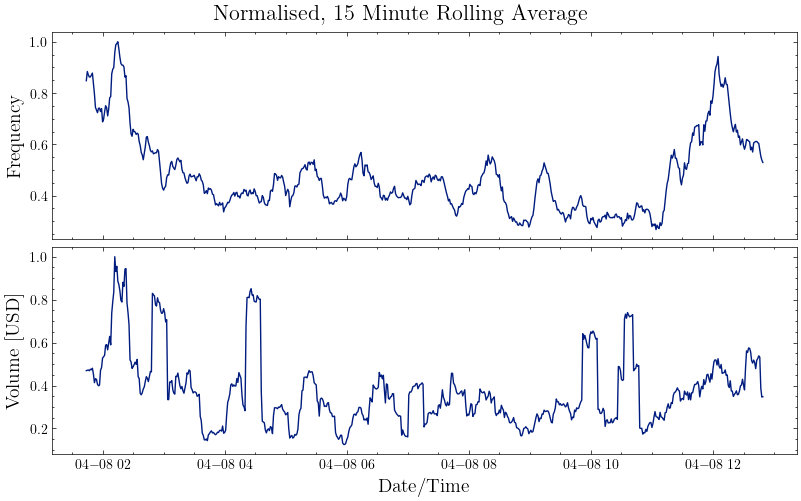

In [22]:
fig1, ax1 = plt.subplots(2,1, sharex=True, constrained_layout = True, figsize = (8,5))

#normalise frequency and volume for same scale
freq_avg_norm = defi_min["freq"].sort_index().rolling(window=15).mean()/np.max(defi_min["freq"].sort_index().rolling(window=15).mean())
vol_avg_norm = defi_min["usd_vol"].sort_index().rolling(window=15).mean()/np.max(defi_min["usd_vol"].sort_index().rolling(window=15).mean())

ax1[0].plot(defi_min.sort_index().index, freq_avg_norm)
ax1[1].plot(defi_min.sort_index().index, vol_avg_norm)
#ax1[0].plot(defi_min.sort_index().index, defi_min["freq"].sort_index())
#ax1[1].plot(defi_min.sort_index().index, defi_min["usd_vol"].sort_index())
#ax1[1].set_yscale("log")
fig1.suptitle("Normalised, 15 Minute Rolling Average", fontsize=fontT)
ax1[0].set_ylabel("Frequency", fontsize=font)
ax1[1].set_ylabel("Volume [USD]", fontsize=font)
ax1[1].set_xlabel("Date/Time", fontsize=font)

## 3. Exploratory Data Analysis

### Volume Charts

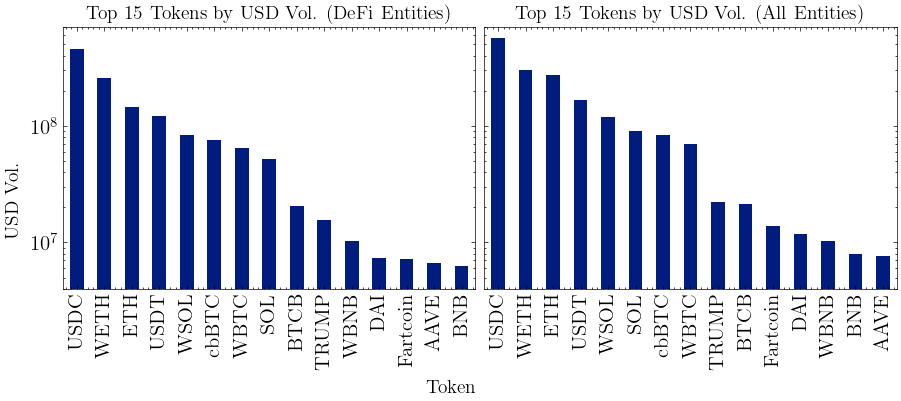

In [23]:
#Volume charts - separated by token

fig2, ax2 = plt.subplots(1,2, constrained_layout=True, figsize = (9,4), sharey=True)


WM_all_vol = (WM_dat.groupby("token", as_index=False)["usd"].sum().rename(columns={"usd": "usd_vol"}))
WM_all_vol = WM_all_vol[WM_all_vol["token"] != "nan"] #Remove NaNs
#WM_all_vol["token"] = WM_all_vol["token"].str.replace('UЅDС - [ t.ly/USPOOL ] - *claim until 17.04.25', "USDC")
#print(WM_all_vol)
WM_all_vol.sort_values("usd_vol", ascending=False).head(15).plot.bar(x="token", y="usd_vol", fontsize=15, ax = ax2[1])
ax2[0].set_yscale("log")
ax2[1].set_title("Top 15 Tokens by USD Vol. (All Entities)", fontsize = font)
ax2[0].set_title("Top 15 Tokens by USD Vol. (DeFi Entities)", fontsize = font)
#ax2[2].set_title("Bottom 15 Tokens by USD Vol. (DeFi Entities)", fontsize = font)

df_defi_vol = (defi_transacs.groupby("token", as_index=False)["usd"].sum().rename(columns={"usd": "usd_vol"}))
df_defi_vol.sort_values("usd_vol", ascending=False).head(15).plot.bar(x="token", y="usd_vol",  fontsize=15, ax = ax2[0])
#df_defi_vol.sort_values("usd_vol", ascending=True).head(15).plot.bar(x="token", y="usd_vol", figsize=(8,5), fontsize=15, ax = ax2[2])
#ax2[2].set_title("Bottom 15 Tokens by USD Vol. (All Tokens)", fontsize = font)
ax2[1].set_yscale("log")
ax2[0].set_yscale("log")


ax2[0].set_xlabel("")
ax2[1].set_xlabel("")
#ax2[2].set_xlabel("")
fig2.supxlabel("Token", fontsize = font)
fig2.supylabel("USD Vol.", fontsize = font)

ax2[0].set_ylim(4*10**6, 7*10**8)
ax2[1].set_ylim(4*10**6, 7*10**8)

ax2[0].legend().remove()
ax2[1].legend().remove()
#ax2[2].legend().remove()


### Heatmaps

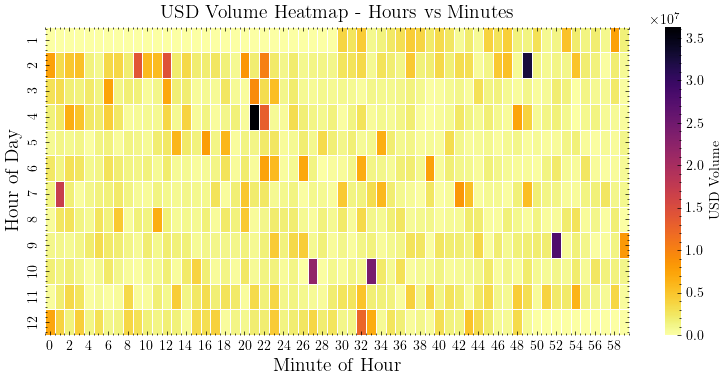

In [24]:
import seaborn as sns

df_m = defi_min
# Extract hour and 15-minute‐bin label (e.g., "00:00", "00:15", ...)
df_m["hour"]    = defi_min.index.hour
df_m["minute"] = defi_min.index.minute  # e.g., "08:15", "10:30", etc.

heat_df = df_m.pivot_table(index="hour", columns="minute", values="usd_vol", aggfunc="sum").fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(heat_df, cmap="inferno_r", linewidths=0.5, cbar_kws={"label": "USD Volume"})
plt.title("USD Volume Heatmap - Hours vs Minutes", fontsize = font)
plt.xlabel("Minute of Hour", fontsize = font)
plt.ylabel("Hour of Day", fontsize = font)
plt.tight_layout()
plt.show()


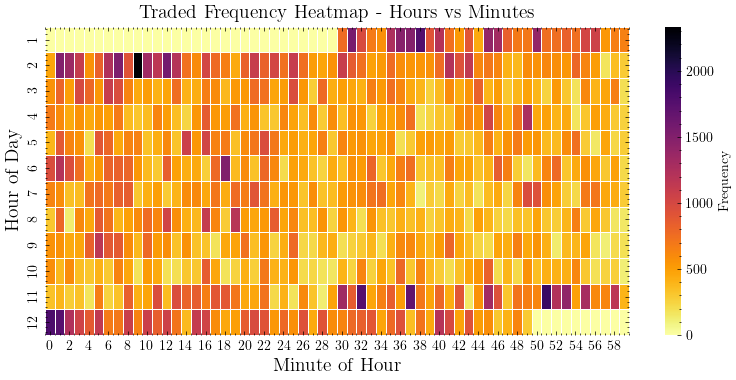

In [25]:
heat_df = df_m.pivot_table(index="hour", columns="minute", values="freq", aggfunc="sum").fillna(0)

plt.figure(figsize=(8, 4))
sns.heatmap(heat_df, cmap="inferno_r", linewidths=0.5, cbar_kws={"label": "Frequency"})
plt.title("Traded Frequency Heatmap - Hours vs Minutes", fontsize = font)
plt.xlabel("Minute of Hour", fontsize = font)
plt.ylabel("Hour of Day", fontsize = font)
plt.tight_layout()
plt.show()

### Frequency Histograms

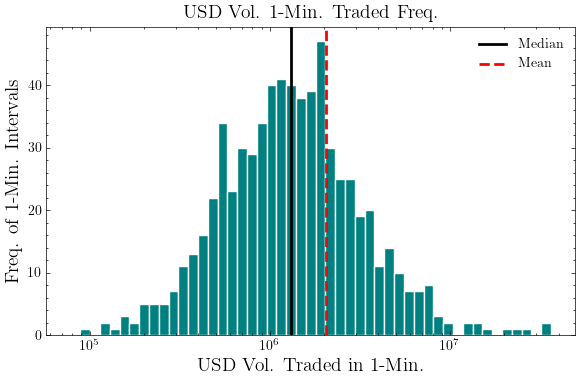

In [26]:
plt.figure(figsize=(6, 4))
log_bins = np.logspace(np.log10(np.min(defi_min["usd_vol"])), np.log10(np.max(defi_min["usd_vol"])), num = 50)
plt.hist(defi_min["usd_vol"], bins=log_bins, color="teal", edgecolor="white")
plt.title("USD Vol. 1-Min. Traded Freq.", fontsize = font)
plt.xlabel("USD Vol. Traded in 1-Min.", fontsize = font)
plt.ylabel("Freq. of 1-Min. Intervals", fontsize = font)
plt.xscale("log")
plt.axvline(np.median(defi_min["usd_vol"]), linewidth = 2, c="black", label = "Median")
plt.axvline(np.mean(defi_min["usd_vol"]), linewidth = 2, c="red", label = "Mean", linestyle = "--")

plt.legend()
plt.tight_layout()
plt.show()